<a href="https://colab.research.google.com/github/jkworldchampion/Military_CodingStudy/blob/main/deeplearning/basic_deeplearning_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/Colab_Notebooks/Machine_learning/book/basic_deeplearning/deep-learning-from-scratch

/content/drive/MyDrive/Colab_Notebooks/Machine_learning/book/basic_deeplearning/deep-learning-from-scratch


# 학습 관련 기술들

이번 장에서는 신경망 학습의 핵심 개념들을 공부할 것이다. 
- 가중치 매개변수의 최적값을 탐색하는 최적화 방법
- 가중치 매개변수 초기값, 하이퍼파라미터 설정 방법
- 오버피칭 대응책인 가중치 감소와 드롭아웃 등의 정규화 방법   
- 마지막으로 최근 많은 연구에서 사용하는 배치 정규화도 알아볼 것이다.  

In [12]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import shuffle_dataset

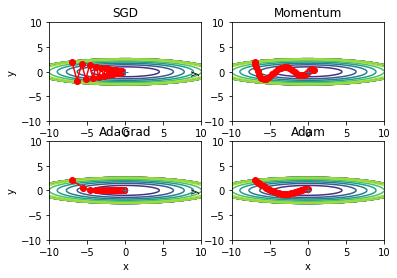

In [3]:
def f(x, y):
    return x**2 / 20.0 + y**2  # 적당한 함수 정의 


def df(x, y):
    return x / 10.0, 2.0*y   # f(x)의 도함수

init_pos = (-7.0, 2.0)  # 시작점을 설정한다.
params = {}  # 파라미터를 담을 공간
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}  # 기울기를 담을 공간
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()   # OrderedDict란 데이터의 순서를 보장해주는 딕셔너리
optimizers["SGD"] = SGD(lr=0.95)  
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)  # Adam은 하이퍼파라미터를 3개를 받는다. 학습률a, 일차모멘텀용 계수b, 이차모멘텀용 계수c

idx = 1

for key in optimizers:
    # 옵티마이저별 초기화 진행
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    # 
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])  # 각각의 기울기를 저장
        optimizer.update(params, grads)  # params['x'], params['y'] 이동
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y)  
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7  
    Z[mask] = 0   # z값이 너무 큰 값은 지저분하기에 안보이게 설정
    
    # 그래프 그리기
    plt.subplot(2, 2, idx)  # 그래프 4개를 그려야함
    idx += 1 
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

## MNIST 데이터셋으로 본 갱신 방법 비교

===========iteration:0===========
SGD:2.4247528615761027
Momentum:2.341454010559797
AdaGrad:1.885465316389527
Adam:2.249201128820892
===========iteration:100===========
SGD:1.265772458097703
Momentum:0.38237970652406406
AdaGrad:0.1627216933139502
Adam:0.20211292334712833
===========iteration:200===========
SGD:0.6837986983302969
Momentum:0.31986907963538896
AdaGrad:0.12100214778886717
Adam:0.2483460864910702
===========iteration:300===========
SGD:0.5936047571259159
Momentum:0.34801997304398646
AdaGrad:0.2035544539625329
Adam:0.25493467412615056
===========iteration:400===========
SGD:0.5003166839831192
Momentum:0.2207711060921176
AdaGrad:0.0889057996959165
Adam:0.17889775557138204
===========iteration:500===========
SGD:0.39150384927956117
Momentum:0.1658726008604223
AdaGrad:0.08042418578442885
Adam:0.14511948690245258
===========iteration:600===========
SGD:0.39120872344836927
Momentum:0.20289470508885327
AdaGrad:0.11808856807886585
Adam:0.15357090554489136
===========iteration:700==

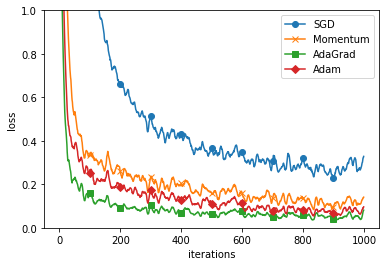

In [4]:
# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 1000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

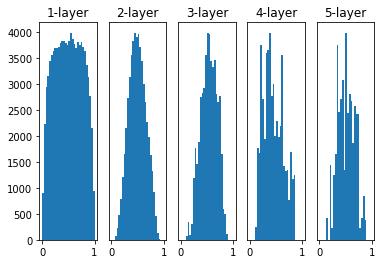

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

===========iteration:0===========
std=0.01:2.302553236436399
Xavier:2.3115598001719544
He:2.4044222663360197
===========iteration:100===========
std=0.01:2.3036760097417863
Xavier:2.221134915070775
He:1.6823530861601947
===========iteration:200===========
std=0.01:2.3028756665986907
Xavier:2.134635569324991
He:0.9433811741256394
===========iteration:300===========
std=0.01:2.3007830821114337
Xavier:1.8031291139963717
He:0.6422324614553183
===========iteration:400===========
std=0.01:2.298406048114913
Xavier:1.2278677069320088
He:0.37613102790779107
===========iteration:500===========
std=0.01:2.2971347440729257
Xavier:0.9353391075854787
He:0.3866131305034245
===========iteration:600===========
std=0.01:2.3021983257955734
Xavier:0.60867542693162
He:0.25934109336091643
===========iteration:700===========
std=0.01:2.300934050447559
Xavier:0.6292373458383975
He:0.36234287334867826
===========iteration:800===========
std=0.01:2.2964464751761424
Xavier:0.3908643067638609
He:0.220272543020717

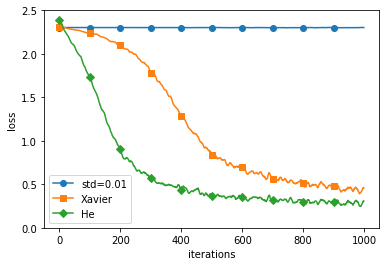

In [6]:
# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 1000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)  # train 전체 사이즈에서  batch_size만큼 복원추출
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

============== 1/16 ==============
epoch:0 | 0.105 - 0.096


/content/drive/MyDrive/Colab_Notebooks/Machine_learning/book/basic_deeplearning/deep-learning-from-scratch/common/multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/content/drive/MyDrive/Colab_Notebooks/Machine_learning/book/basic_deeplearning/deep-learning-from-scratch/common/multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:1 | 0.097 - 0.098
epoch:2 | 0.097 - 0.117
epoch:3 | 0.097 - 0.129
epoch:4 | 0.097 - 0.164
epoch:5 | 0.097 - 0.178
epoch:6 | 0.097 - 0.195
epoch:7 | 0.097 - 0.223
epoch:8 | 0.097 - 0.242
epoch:9 | 0.097 - 0.263
epoch:10 | 0.097 - 0.283
epoch:11 | 0.097 - 0.308
epoch:12 | 0.097 - 0.313
epoch:13 | 0.097 - 0.333
epoch:14 | 0.097 - 0.354
epoch:15 | 0.097 - 0.361
epoch:16 | 0.097 - 0.374
epoch:17 | 0.097 - 0.396
epoch:18 | 0.097 - 0.412


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.419
============== 2/16 ==============
epoch:0 | 0.097 - 0.124


/content/drive/MyDrive/Colab_Notebooks/Machine_learning/book/basic_deeplearning/deep-learning-from-scratch/common/multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/content/drive/MyDrive/Colab_Notebooks/Machine_learning/book/basic_deeplearning/deep-learning-from-scratch/common/multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/content/drive/MyDrive/Colab_Notebooks/Machine_learning/book/basic_deeplearning/deep-learning-from-scratch/common/functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)


epoch:1 | 0.097 - 0.143
epoch:2 | 0.097 - 0.18
epoch:3 | 0.097 - 0.224
epoch:4 | 0.097 - 0.247
epoch:5 | 0.097 - 0.266
epoch:6 | 0.097 - 0.291
epoch:7 | 0.097 - 0.307
epoch:8 | 0.097 - 0.328
epoch:9 | 0.097 - 0.355
epoch:10 | 0.097 - 0.381
epoch:11 | 0.097 - 0.41
epoch:12 | 0.097 - 0.415
epoch:13 | 0.097 - 0.436
epoch:14 | 0.097 - 0.457
epoch:15 | 0.097 - 0.483
epoch:16 | 0.097 - 0.492
epoch:17 | 0.097 - 0.512
epoch:18 | 0.097 - 0.519


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.53
============== 3/16 ==============
epoch:0 | 0.188 - 0.108
epoch:1 | 0.451 - 0.126
epoch:2 | 0.603 - 0.161
epoch:3 | 0.7 - 0.193
epoch:4 | 0.764 - 0.218
epoch:5 | 0.816 - 0.26
epoch:6 | 0.87 - 0.315
epoch:7 | 0.886 - 0.354
epoch:8 | 0.926 - 0.395
epoch:9 | 0.942 - 0.423
epoch:10 | 0.961 - 0.453
epoch:11 | 0.972 - 0.479
epoch:12 | 0.981 - 0.511
epoch:13 | 0.983 - 0.542
epoch:14 | 0.986 - 0.569
epoch:15 | 0.991 - 0.587
epoch:16 | 0.993 - 0.599
epoch:17 | 0.995 - 0.62
epoch:18 | 0.996 - 0.626
epoch:19 | 0.996 - 0.643

No handles with labels found to put in legend.



============== 4/16 ==============
epoch:0 | 0.08 - 0.083
epoch:1 | 0.232 - 0.115
epoch:2 | 0.377 - 0.211
epoch:3 | 0.478 - 0.293
epoch:4 | 0.563 - 0.365
epoch:5 | 0.607 - 0.409
epoch:6 | 0.655 - 0.464
epoch:7 | 0.682 - 0.502
epoch:8 | 0.716 - 0.539
epoch:9 | 0.737 - 0.568
epoch:10 | 0.757 - 0.593
epoch:11 | 0.776 - 0.623
epoch:12 | 0.784 - 0.641
epoch:13 | 0.81 - 0.66
epoch:14 | 0.812 - 0.679
epoch:15 | 0.829 - 0.692
epoch:16 | 0.839 - 0.708
epoch:17 | 0.85 - 0.732
epoch:18 | 0.857 - 0.744


No handles with labels found to put in legend.


epoch:19 | 0.865 - 0.753
============== 5/16 ==============
epoch:0 | 0.113 - 0.131
epoch:1 | 0.122 - 0.136
epoch:2 | 0.128 - 0.195
epoch:3 | 0.136 - 0.329
epoch:4 | 0.147 - 0.441
epoch:5 | 0.166 - 0.525
epoch:6 | 0.198 - 0.588
epoch:7 | 0.235 - 0.631
epoch:8 | 0.256 - 0.673
epoch:9 | 0.278 - 0.704
epoch:10 | 0.283 - 0.727
epoch:11 | 0.3 - 0.756
epoch:12 | 0.312 - 0.774
epoch:13 | 0.329 - 0.793
epoch:14 | 0.33 - 0.815
epoch:15 | 0.346 - 0.828
epoch:16 | 0.36 - 0.84
epoch:17 | 0.366 - 0.857
epoch:18 | 0.373 - 0.862


No handles with labels found to put in legend.


epoch:19 | 0.378 - 0.865
============== 6/16 ==============
epoch:0 | 0.092 - 0.108
epoch:1 | 0.088 - 0.163
epoch:2 | 0.149 - 0.435
epoch:3 | 0.122 - 0.619
epoch:4 | 0.165 - 0.712
epoch:5 | 0.126 - 0.764
epoch:6 | 0.177 - 0.798
epoch:7 | 0.155 - 0.822
epoch:8 | 0.164 - 0.845
epoch:9 | 0.18 - 0.857
epoch:10 | 0.186 - 0.869
epoch:11 | 0.178 - 0.879
epoch:12 | 0.129 - 0.891
epoch:13 | 0.129 - 0.896
epoch:14 | 0.192 - 0.909
epoch:15 | 0.185 - 0.918
epoch:16 | 0.128 - 0.926
epoch:17 | 0.179 - 0.933
epoch:18 | 0.187 - 0.94


No handles with labels found to put in legend.


epoch:19 | 0.191 - 0.946
============== 7/16 ==============
epoch:0 | 0.119 - 0.119
epoch:1 | 0.117 - 0.255
epoch:2 | 0.117 - 0.586
epoch:3 | 0.117 - 0.724
epoch:4 | 0.117 - 0.784
epoch:5 | 0.117 - 0.829
epoch:6 | 0.117 - 0.865
epoch:7 | 0.117 - 0.88
epoch:8 | 0.117 - 0.898
epoch:9 | 0.117 - 0.927
epoch:10 | 0.117 - 0.937
epoch:11 | 0.117 - 0.951
epoch:12 | 0.117 - 0.954
epoch:13 | 0.117 - 0.963
epoch:14 | 0.117 - 0.968
epoch:15 | 0.117 - 0.967
epoch:16 | 0.117 - 0.978
epoch:17 | 0.117 - 0.98
epoch:18 | 0.117 - 0.985


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.989
============== 8/16 ==============
epoch:0 | 0.116 - 0.089
epoch:1 | 0.117 - 0.398
epoch:2 | 0.117 - 0.711
epoch:3 | 0.116 - 0.833
epoch:4 | 0.116 - 0.876
epoch:5 | 0.116 - 0.9
epoch:6 | 0.116 - 0.929
epoch:7 | 0.116 - 0.953
epoch:8 | 0.116 - 0.966
epoch:9 | 0.116 - 0.974
epoch:10 | 0.116 - 0.987
epoch:11 | 0.117 - 0.99
epoch:12 | 0.117 - 0.994
epoch:13 | 0.116 - 0.994
epoch:14 | 0.116 - 0.995
epoch:15 | 0.116 - 0.997
epoch:16 | 0.117 - 0.997
epoch:17 | 0.117 - 0.997
epoch:18 | 0.116 - 0.997


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.997
============== 9/16 ==============
epoch:0 | 0.117 - 0.118
epoch:1 | 0.116 - 0.537
epoch:2 | 0.116 - 0.711
epoch:3 | 0.117 - 0.786
epoch:4 | 0.116 - 0.856
epoch:5 | 0.116 - 0.892
epoch:6 | 0.116 - 0.933
epoch:7 | 0.116 - 0.954
epoch:8 | 0.117 - 0.974
epoch:9 | 0.117 - 0.988
epoch:10 | 0.117 - 0.99
epoch:11 | 0.117 - 0.989
epoch:12 | 0.117 - 0.996
epoch:13 | 0.117 - 0.996
epoch:14 | 0.117 - 0.998
epoch:15 | 0.117 - 0.999
epoch:16 | 0.117 - 0.999
epoch:17 | 0.117 - 0.999
epoch:18 | 0.117 - 0.999


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.999
============== 10/16 ==============
epoch:0 | 0.105 - 0.162
epoch:1 | 0.116 - 0.465
epoch:2 | 0.116 - 0.601
epoch:3 | 0.116 - 0.671
epoch:4 | 0.116 - 0.776
epoch:5 | 0.116 - 0.83
epoch:6 | 0.116 - 0.921
epoch:7 | 0.116 - 0.913
epoch:8 | 0.116 - 0.932
epoch:9 | 0.116 - 0.96
epoch:10 | 0.116 - 0.968
epoch:11 | 0.116 - 0.986
epoch:12 | 0.116 - 0.991
epoch:13 | 0.116 - 0.994
epoch:14 | 0.116 - 0.983
epoch:15 | 0.116 - 0.992
epoch:16 | 0.116 - 0.997
epoch:17 | 0.116 - 0.997
epoch:18 | 0.116 - 0.997


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.997
============== 11/16 ==============
epoch:0 | 0.097 - 0.134
epoch:1 | 0.116 - 0.567
epoch:2 | 0.117 - 0.555
epoch:3 | 0.117 - 0.677
epoch:4 | 0.117 - 0.692
epoch:5 | 0.117 - 0.671
epoch:6 | 0.117 - 0.691
epoch:7 | 0.116 - 0.738
epoch:8 | 0.116 - 0.809
epoch:9 | 0.116 - 0.752
epoch:10 | 0.116 - 0.875
epoch:11 | 0.117 - 0.893
epoch:12 | 0.117 - 0.897
epoch:13 | 0.117 - 0.9
epoch:14 | 0.117 - 0.901
epoch:15 | 0.117 - 0.918
epoch:16 | 0.117 - 0.897
epoch:17 | 0.117 - 0.903
epoch:18 | 0.117 - 0.911


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.935
============== 12/16 ==============
epoch:0 | 0.116 - 0.146
epoch:1 | 0.117 - 0.448
epoch:2 | 0.117 - 0.53
epoch:3 | 0.117 - 0.585
epoch:4 | 0.117 - 0.597
epoch:5 | 0.117 - 0.608
epoch:6 | 0.117 - 0.602
epoch:7 | 0.117 - 0.662
epoch:8 | 0.117 - 0.683
epoch:9 | 0.117 - 0.672
epoch:10 | 0.117 - 0.693
epoch:11 | 0.117 - 0.699
epoch:12 | 0.117 - 0.448
epoch:13 | 0.117 - 0.676
epoch:14 | 0.116 - 0.681
epoch:15 | 0.117 - 0.704
epoch:16 | 0.117 - 0.711
epoch:17 | 0.116 - 0.709
epoch:18 | 0.117 - 0.716


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.714
============== 13/16 ==============
epoch:0 | 0.097 - 0.179
epoch:1 | 0.116 - 0.461
epoch:2 | 0.116 - 0.482
epoch:3 | 0.116 - 0.556
epoch:4 | 0.117 - 0.582
epoch:5 | 0.116 - 0.604
epoch:6 | 0.116 - 0.615
epoch:7 | 0.116 - 0.615
epoch:8 | 0.116 - 0.618
epoch:9 | 0.116 - 0.599
epoch:10 | 0.116 - 0.643
epoch:11 | 0.116 - 0.654
epoch:12 | 0.116 - 0.648
epoch:13 | 0.117 - 0.669
epoch:14 | 0.117 - 0.679
epoch:15 | 0.117 - 0.688
epoch:16 | 0.117 - 0.685
epoch:17 | 0.117 - 0.682
epoch:18 | 0.117 - 0.664
epoch:19 | 0.117 - 0.689


No handles with labels found to put in legend.


============== 14/16 ==============
epoch:0 | 0.094 - 0.104
epoch:1 | 0.097 - 0.477
epoch:2 | 0.117 - 0.557
epoch:3 | 0.117 - 0.589
epoch:4 | 0.117 - 0.589
epoch:5 | 0.117 - 0.597
epoch:6 | 0.117 - 0.596
epoch:7 | 0.117 - 0.594
epoch:8 | 0.117 - 0.603
epoch:9 | 0.117 - 0.604
epoch:10 | 0.117 - 0.611
epoch:11 | 0.117 - 0.612
epoch:12 | 0.117 - 0.576
epoch:13 | 0.117 - 0.61
epoch:14 | 0.117 - 0.617
epoch:15 | 0.117 - 0.615
epoch:16 | 0.117 - 0.681
epoch:17 | 0.117 - 0.688
epoch:18 | 0.117 - 0.704


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.618
============== 15/16 ==============
epoch:0 | 0.105 - 0.176
epoch:1 | 0.117 - 0.318
epoch:2 | 0.117 - 0.399
epoch:3 | 0.117 - 0.4
epoch:4 | 0.117 - 0.411
epoch:5 | 0.117 - 0.425
epoch:6 | 0.117 - 0.428
epoch:7 | 0.117 - 0.424
epoch:8 | 0.117 - 0.425
epoch:9 | 0.117 - 0.429
epoch:10 | 0.117 - 0.433
epoch:11 | 0.117 - 0.433
epoch:12 | 0.117 - 0.496
epoch:13 | 0.116 - 0.514
epoch:14 | 0.116 - 0.524
epoch:15 | 0.116 - 0.521
epoch:16 | 0.116 - 0.526
epoch:17 | 0.116 - 0.527
epoch:18 | 0.116 - 0.499
epoch:19 | 0.116 - 0.529


No handles with labels found to put in legend.


============== 16/16 ==============
epoch:0 | 0.117 - 0.18
epoch:1 | 0.092 - 0.206
epoch:2 | 0.116 - 0.268
epoch:3 | 0.116 - 0.401
epoch:4 | 0.116 - 0.423
epoch:5 | 0.116 - 0.426
epoch:6 | 0.116 - 0.413
epoch:7 | 0.116 - 0.483
epoch:8 | 0.117 - 0.501
epoch:9 | 0.117 - 0.508
epoch:10 | 0.117 - 0.51
epoch:11 | 0.117 - 0.52
epoch:12 | 0.117 - 0.516
epoch:13 | 0.117 - 0.519
epoch:14 | 0.117 - 0.521
epoch:15 | 0.117 - 0.523
epoch:16 | 0.117 - 0.526
epoch:17 | 0.117 - 0.53
epoch:18 | 0.117 - 0.531
epoch:19 | 0.117 - 0.53


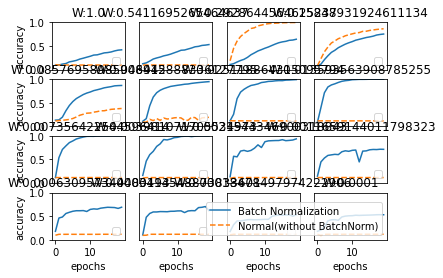

In [7]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

epoch:0, train acc:0.11, test acc:0.1295
epoch:1, train acc:0.16666666666666666, test acc:0.1668
epoch:2, train acc:0.2, test acc:0.1951
epoch:3, train acc:0.22333333333333333, test acc:0.2237
epoch:4, train acc:0.24333333333333335, test acc:0.2431
epoch:5, train acc:0.2633333333333333, test acc:0.2595
epoch:6, train acc:0.29333333333333333, test acc:0.2669
epoch:7, train acc:0.3233333333333333, test acc:0.2708
epoch:8, train acc:0.31333333333333335, test acc:0.2829
epoch:9, train acc:0.3466666666666667, test acc:0.3074
epoch:10, train acc:0.36333333333333334, test acc:0.3145
epoch:11, train acc:0.37666666666666665, test acc:0.3225
epoch:12, train acc:0.4066666666666667, test acc:0.3409
epoch:13, train acc:0.4266666666666667, test acc:0.3562
epoch:14, train acc:0.46, test acc:0.372
epoch:15, train acc:0.4766666666666667, test acc:0.3801
epoch:16, train acc:0.48, test acc:0.3958
epoch:17, train acc:0.5066666666666667, test acc:0.4027
epoch:18, train acc:0.5233333333333333, test acc:0.41

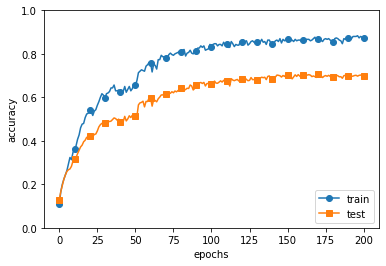

In [8]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

train loss:2.3021992368670467
=== epoch:1, train acc:0.10333333333333333, test acc:0.1058 ===
train loss:2.2950822174268803
train loss:2.2816163335442816
train loss:2.282618250152602
=== epoch:2, train acc:0.11666666666666667, test acc:0.1098 ===
train loss:2.3041121729604486
train loss:2.2837538841498914
train loss:2.2987375128782683
=== epoch:3, train acc:0.11, test acc:0.1142 ===
train loss:2.283178840086326
train loss:2.2906656849436713
train loss:2.2960575054209285
=== epoch:4, train acc:0.13, test acc:0.119 ===
train loss:2.2881046977417507
train loss:2.2730880010064483
train loss:2.296771516011382
=== epoch:5, train acc:0.13666666666666666, test acc:0.1217 ===
train loss:2.286240111457279
train loss:2.2882614116802995
train loss:2.2944909434203034
=== epoch:6, train acc:0.15, test acc:0.1258 ===
train loss:2.284364182638613
train loss:2.2905581137785536
train loss:2.276029706159565
=== epoch:7, train acc:0.15666666666666668, test acc:0.1323 ===
train loss:2.284164290438682
train

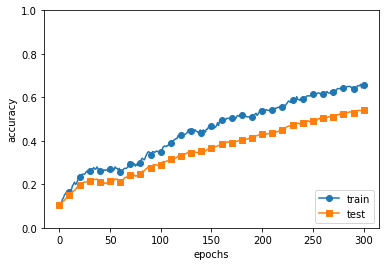

In [9]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

val acc:0.14 | lr:1.3315581407432908e-06, weight decay:1.6404726563643837e-07
val acc:0.63 | lr:0.004093173443949423, weight decay:3.21653714644945e-05
val acc:0.17 | lr:7.969280612202189e-05, weight decay:2.8403128908117355e-07
val acc:0.11 | lr:1.6829443103259045e-05, weight decay:1.965248180034254e-08
val acc:0.08 | lr:2.0555418816655217e-06, weight decay:6.031865821978236e-07
val acc:0.07 | lr:9.709473405093685e-06, weight decay:2.996855147207121e-07
val acc:0.13 | lr:0.00020222454240918135, weight decay:2.1335541961941853e-06
val acc:0.11 | lr:2.651667306777393e-06, weight decay:1.3894169950668396e-08
val acc:0.16 | lr:4.369457850669047e-05, weight decay:1.4003657305157426e-07
val acc:0.81 | lr:0.00523223907009979, weight decay:6.775098746586983e-08
val acc:0.12 | lr:0.0003789964707954224, weight decay:8.860910782745816e-07
val acc:0.24 | lr:0.0017979737808428012, weight decay:1.3083293940198418e-05
val acc:0.19 | lr:0.0001854013235001464, weight decay:4.037056841971588e-05
val ac

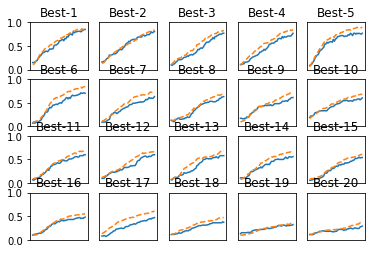

In [11]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()